In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- Config ---
TRAIN_FILE = 'Patient_Training_Dataset.xlsx'
TEST_FILE = 'Cleaned_New_Patient_Health_Data.csv'
ECG_LENGTH = 200
BATCH_SIZE = 32
EPOCHS = 15
LR = 0.001

# --- Dataset Classes ---
class TrainPatientDataset(Dataset):
    def __init__(self, df):
        self.X = torch.tensor(df.iloc[:, 4:-1].values.astype(np.float32)).unsqueeze(1)  # (N, 1, ECG_LEN)
        self.y = torch.tensor(df['label'].values.astype(np.int64))

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class TestPatientDataset(Dataset):
    def __init__(self, df):
        # Simulate ECG array from single ECG column if needed
        if 'ecg' in df.columns:
            ecg_col = df['ecg'].astype(np.float32).values
            ecg_matrix = np.tile(ecg_col.reshape(-1, 1), (1, ECG_LENGTH))  # shape: (N, 200)
        else:
            ecg_matrix = df.iloc[:, 3:3+ECG_LENGTH].values.astype(np.float32)
        self.X = torch.tensor(ecg_matrix).unsqueeze(1)  # (N, 1, ECG_LEN)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

# --- Model ---
class ECGCNN(nn.Module):
    def __init__(self):
        super(ECGCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, 5, padding=2), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(16, 32, 5, padding=2), nn.ReLU(), nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear(32 * (ECG_LENGTH // 4), 64), nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.cnn(x)

# --- Training ---
train_df = pd.read_excel(TRAIN_FILE)
scaler = StandardScaler()
train_df.iloc[:, 4:-1] = scaler.fit_transform(train_df.iloc[:, 4:-1])
train_dataset = TrainPatientDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = ECGCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}")

# --- Testing ---
test_df = pd.read_csv(TEST_FILE)
scaler_vals = np.tile(np.mean(train_df.iloc[:, 4:-1].values, axis=0), (len(test_df), 1))
test_dataset = TestPatientDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model.eval()
predictions = []
with torch.no_grad():
    for X_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())

test_df['Predicted_Label'] = predictions

test_output_path = 'Predicted_Test_Results.csv'
test_df.to_csv(test_output_path, index=False)
print(f"Saved predictions to {test_output_path}")


Epoch 1/15, Loss: 11.2649
Epoch 2/15, Loss: 10.9472
Epoch 3/15, Loss: 10.5868
Epoch 4/15, Loss: 9.8865
Epoch 5/15, Loss: 9.2786
Epoch 6/15, Loss: 8.5868
Epoch 7/15, Loss: 7.3106
Epoch 8/15, Loss: 6.3087
Epoch 9/15, Loss: 5.1056
Epoch 10/15, Loss: 4.4546
Epoch 11/15, Loss: 4.2633
Epoch 12/15, Loss: 3.2952
Epoch 13/15, Loss: 2.0443
Epoch 14/15, Loss: 1.4597
Epoch 15/15, Loss: 1.0714
Saved predictions to Predicted_Test_Results.csv


In [4]:
import pandas as pd
df = pd.read_csv("Predicted_Test_Results.csv")
df.head(10)  # view first 10 predictions


,Unnamed: 0,timestamp,ecg,heart_rate,spo2,temperature,date (Asia/Karachi),Predicted_Label
0,14,2/8/2025 10:20,1024,94.918045,94,36.8750,2025-02-08 14:11:52.189000+05:00,0
1,15,2/8/2025 10:20,1024,64.028610,94,44.5625,2025-02-08 14:11:36.200000+05:00,0
2,16,2/8/2025 10:20,1024,37.547688,94,37.5625,2025-02-08 14:11:20.169000+05:00,0
3,19,2/8/2025 10:20,1024,89.801064,94,35.3750,2025-02-08 14:10:31.907000+05:00,0
4,20,2/8/2025 10:20,1024,48.002388,95,37.1250,2025-02-08 14:10:15.933000+05:00,0
5,21,2/8/2025 10:20,1024,45.821785,94,31.8750,2025-02-08 14:09:59.953000+05:00,0
6,34,2/8/2025 10:20,1024,82.787865,93,39.5625,2025-02-08 14:06:31.353000+05:00,0
7,35,2/8/2025 10:20,1024,83.034424,94,29.7500,2025-02-08 14:06:15.316000+05:00,0
8,41,2/8/2025 10:20,1024,107.621796,94,51.2500,2025-02-08 14:04:39.243000+05:00,0
9,53,2/8/2025 10:20,1004,41.013191,94,22.8125,2025-02-08 14:01:26.731000+05:00,0


<Axes: title={'center': 'Prediction Summary'}, xlabel='Label (0=Normal, 1=Abnormal)', ylabel='Count'>

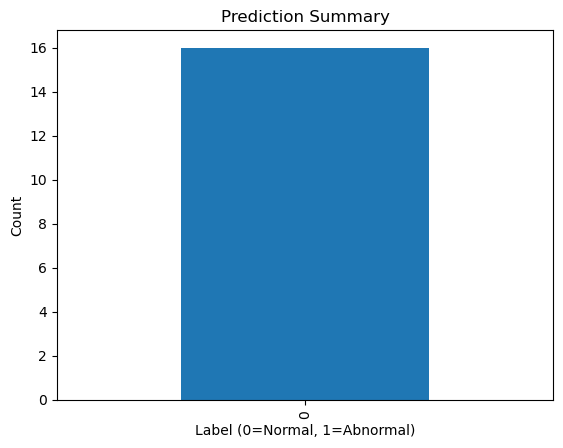

In [5]:
df['Predicted_Label'].value_counts().plot(kind='bar', title='Prediction Summary', xlabel='Label (0=Normal, 1=Abnormal)', ylabel='Count')


In [6]:
import torch
torch.save(model.state_dict(), "patient_health_model.pth")


In [7]:
model.load_state_dict(torch.load("patient_health_model.pth"))
model.eval()


ECGCNN(
  (cnn): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1600, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

true_labels = test_df['label']  # only if your test CSV has this column
pred_labels = test_df['Predicted_Label']

print(confusion_matrix(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))


KeyError: 'label'

In [9]:
test_df[['Predicted_Label']].value_counts()


Predicted_Label
0                  16
Name: count, dtype: int64

In [10]:
import pandas as pd

df = pd.read_csv("Predicted_Test_Results.csv")
df.head(10)  # View first 10 rows with predictions


,Unnamed: 0,timestamp,ecg,heart_rate,spo2,temperature,date (Asia/Karachi),Predicted_Label
0,14,2/8/2025 10:20,1024,94.918045,94,36.8750,2025-02-08 14:11:52.189000+05:00,0
1,15,2/8/2025 10:20,1024,64.028610,94,44.5625,2025-02-08 14:11:36.200000+05:00,0
2,16,2/8/2025 10:20,1024,37.547688,94,37.5625,2025-02-08 14:11:20.169000+05:00,0
3,19,2/8/2025 10:20,1024,89.801064,94,35.3750,2025-02-08 14:10:31.907000+05:00,0
4,20,2/8/2025 10:20,1024,48.002388,95,37.1250,2025-02-08 14:10:15.933000+05:00,0
5,21,2/8/2025 10:20,1024,45.821785,94,31.8750,2025-02-08 14:09:59.953000+05:00,0
6,34,2/8/2025 10:20,1024,82.787865,93,39.5625,2025-02-08 14:06:31.353000+05:00,0
7,35,2/8/2025 10:20,1024,83.034424,94,29.7500,2025-02-08 14:06:15.316000+05:00,0
8,41,2/8/2025 10:20,1024,107.621796,94,51.2500,2025-02-08 14:04:39.243000+05:00,0
9,53,2/8/2025 10:20,1004,41.013191,94,22.8125,2025-02-08 14:01:26.731000+05:00,0


In [12]:
TRAIN_FILE = 'Patient_Training_Dataset.xlsx'
train_df = pd.read_excel(TRAIN_FILE)


In [13]:
TRAIN_FILE = 'Patient_Training_Dataset.xlsx'
train_df = pd.read_excel(TRAIN_FILE)


In [14]:
train_df = pd.read_excel(TRAIN_FILE)


In [15]:
import pandas as pd
df = pd.read_csv("Predicted_Test_Results.csv")
df.head(10)  # show top 10 predicted rows


,Unnamed: 0,timestamp,ecg,heart_rate,spo2,temperature,date (Asia/Karachi),Predicted_Label
0,14,2/8/2025 10:20,1024,94.918045,94,36.8750,2025-02-08 14:11:52.189000+05:00,0
1,15,2/8/2025 10:20,1024,64.028610,94,44.5625,2025-02-08 14:11:36.200000+05:00,0
2,16,2/8/2025 10:20,1024,37.547688,94,37.5625,2025-02-08 14:11:20.169000+05:00,0
3,19,2/8/2025 10:20,1024,89.801064,94,35.3750,2025-02-08 14:10:31.907000+05:00,0
4,20,2/8/2025 10:20,1024,48.002388,95,37.1250,2025-02-08 14:10:15.933000+05:00,0
5,21,2/8/2025 10:20,1024,45.821785,94,31.8750,2025-02-08 14:09:59.953000+05:00,0
6,34,2/8/2025 10:20,1024,82.787865,93,39.5625,2025-02-08 14:06:31.353000+05:00,0
7,35,2/8/2025 10:20,1024,83.034424,94,29.7500,2025-02-08 14:06:15.316000+05:00,0
8,41,2/8/2025 10:20,1024,107.621796,94,51.2500,2025-02-08 14:04:39.243000+05:00,0
9,53,2/8/2025 10:20,1004,41.013191,94,22.8125,2025-02-08 14:01:26.731000+05:00,0
